# &#x26F3; Model building of golf putting with Turing.jl

In [5]:
using DataFrames, HTTP, CSV

In [9]:
resp = HTTP.get("https://raw.githubusercontent.com/stan-dev/example-models/master/knitr/golf/golf_data.txt");
data = CSV.read(IOBuffer(resp.body), normalizenames = true, header = 3, DataFrame);

In [15]:
x, nⱼ, y = (data[:,1], data[:,2], data[:,3]);

$$
\sqrt{\frac{P_\hat{j}(1 - P_\hat{j})}{n_\hat{j}}}
$$

In [16]:
Pⱼ = y ./ nⱼ
error = @. sqrt((Pⱼ * (1 - Pⱼ) / nⱼ));

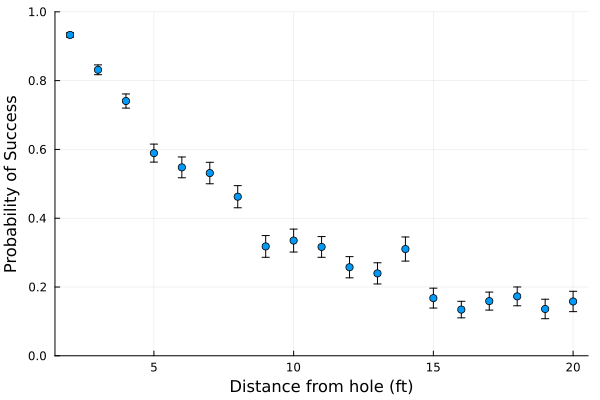

In [17]:
using Plots

# plot out the error
scatter(
  x, Pⱼ,
  yerror= error,
  legend = false,
  ylim = (0, 1),
  ylab = "Probability of Success",
  xlab = "Distance from hole (ft)")

In [18]:
using StatsFuns: logistic

In [22]:
using Turing
# Hide sampling progress.
Turing.setprogress!(false);

[ Info: [Turing]: progress logging is disabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as false


In [23]:
@model golf_logistic(x,y,n,J) = begin
  # parameters
  a ~ Normal(0, 1)
  b ~ Normal(0, 1)

  # model
  for i in 1:J
    p = logistic(a + b * x[i])
    y[i] ~ Binomial(n[i], p)
  end
end

golf_logistic (generic function with 2 methods)

In [24]:
chn = sample(golf_logistic(x, y, n, length(x)), NUTS(), MCMCThreads(), 4000, 4);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.0125
┌ Info: Found initial step size
└   ϵ = 0.0125


In [25]:
using PrettyTables

In [26]:
formatters = (v,i,j) -> (j > 1) ? round(v, digits=3) : v

function prettystats(chains)
  chains |>
    x -> summarystats(x) |>
    x -> DataFrame(x) |>
    x -> pretty_table(x, backend = :html, formatters = formatters)
end

prettystats (generic function with 1 method)

In [27]:
prettystats(chn)

parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
a,2.225,0.059,0.001,4073.92,5227.23,1.002,927.155
b,-0.255,0.007,0.0,4163.24,5500.02,1.002,947.482


In [36]:
a_post = median(chn[:a])
b_post = median(chn[:b])

# iterator for distance from hole calcs
xrng = 1:1:21
post_lines = [logistic(a_post + b_post * x) for x = xrng];

In [39]:
using StatsBase: sample

In [40]:
# 50 draws from the posterior
a_samp = sample(chn[:a], 50)
b_samp = sample(chn[:b], 50)

post_samp = [logistic(a_samp[i] + b_samp[i] * x) for x = xrng, i = 1:50];

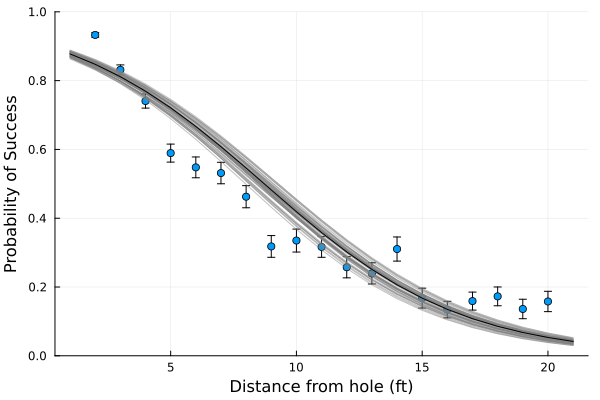

In [41]:
plot!(post_samp, alpha = 0.5, color = :gray) # add uncertainty samples
plot!(post_lines, color = :black) # add median

## First Principles

In [42]:
Φ(x) = cdf.(Normal(0, 1), x);

In [43]:
@model golf_angle(x, y, n, J, r, R) = begin
  # transformed data
  threshold_angle = asin.((R - r) ./ x)

  # parameters
  σ ~ truncated(Normal(0, 1), 0, Inf)

  # model
  p = 2 * Φ(threshold_angle / σ) .- 1
  for i in 1:J
    y[i] ~ Binomial(n[i], p[i])
  end
end

golf_angle (generic function with 2 methods)

In [44]:
# radius of ball and hole respectively
r = (1.68 / 2) / 12
R = (4.25 / 2) / 12

0.17708333333333334

In [45]:
prior = sample(golf_angle(x, y, n, length(x), r, R), Prior(), 4000)

Chains MCMC chain (4000×2×1 Array{Float64, 3}):

Iterations        = 1:1:4000
Number of chains  = 1
Samples per chain = 4000
Wall duration     = 0.08 seconds
Compute duration  = 0.08 seconds
parameters        = σ
internals         = lp

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    0.8136    0.6172    0.0098   4055.9233   3727.0844    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0271    0.3316    0.6797    1.1720    2.3343


In [49]:
angle_prior = sample(prior[:σ], 500)
angle_of_shot = rand.(Normal.(0, angle_prior), 1)  # radians
angle_of_shot = getindex.(angle_of_shot) # extract array

distance = 20 # feet

end_positions = [
    distance * cos.(angle_of_shot),
    distance * sin.(angle_of_shot)
];

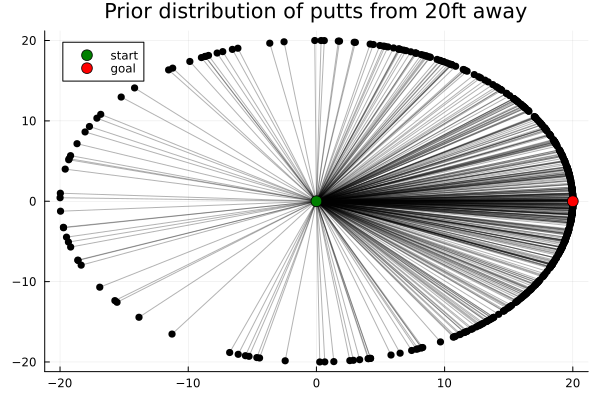

In [50]:
# visualize
 plot(
   [[0, i] for i in end_positions[1]],
   [[0, i] for i in end_positions[2]],
   labels = false,
   legend = :topleft,
   color = :black,
   alpha = 0.3,
   title = "Prior distribution of putts from 20ft away"
   )
scatter!(end_positions[1], end_positions[2], color = :black, labels = false)
scatter!((0,0), color = :green, label = "start", markersize = 6)
scatter!((20, 0), color = :red, label = "goal", markersize = 6)

In [60]:
# Now for the estimation of the parameters:
chn2 = sample(golf_angle(x, y, n, length(x), r, R), NUTS(), MCMCThreads(), 4000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.05


Chains MCMC chain (4000×13×4 Array{Float64, 3}):

Iterations        = 1001:1:5000
Number of chains  = 4
Samples per chain = 4000
Wall duration     = 0.62 seconds
Compute duration  = 0.57 seconds
parameters        = σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk     ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64     Float64      Float64   Float64  ⋯

           σ    0.0267    0.0004    0.0000   6052.4011   10714.6834    1.0002  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0259    0.0264    0.0266    0.0269    0.0274


In [61]:
# chn2 = hcat(chn2, Chains(chn2[:σ] * 180 / π, ["sigma_degrees"]))
# ArgumentError: the length of each axis must match the corresponding size of data

In [62]:
prettystats(chn2)

parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
σ,0.027,0.0,0.0,6052.4,10714.7,1.0,10599.7


In [65]:
# calculate predictions and see how this model compares to the logistic model. 
prob_angle(threshold, σ) = 2 * Φ(threshold / σ) .- 1

prob_angle (generic function with 1 method)

In [67]:
# calculate predictions
post_sigma = median(chn2[:σ])
threshold_angle = [asin((R - r) / x) for x = xrng]
geom_lines = prob_angle(threshold_angle, post_sigma);

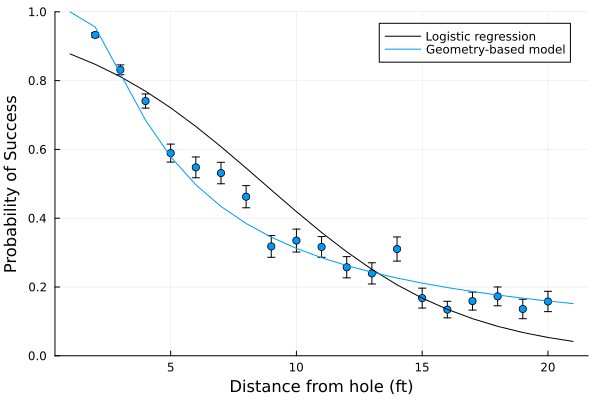

In [68]:
scatter(
  x, pj,
  yerror= error,
  label = "",
  ylim = (0, 1),
  ylab = "Probability of Success",
  xlab = "Distance from hole (ft)")
plot!(post_lines, color = :black, label = "Logistic regression")
plot!(geom_lines, color = 1, label = "Geometry-based model")

In [70]:
# perform a posterior predictive check:
angle_post = sample(chn2[:σ], 500)
angle_of_shot = rand.(Normal.(0, angle_post), 1)  # radians
angle_of_shot = getindex.(angle_of_shot) # extract array

distance = 20 # feet

end_positions = [
    distance * cos.(angle_of_shot),
    distance * sin.(angle_of_shot)
];

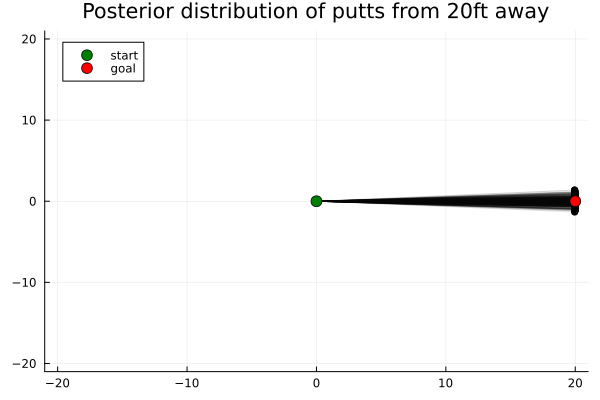

In [71]:
# visualize
plot(
  [[0, i] for i in end_positions[1]],
  [[0, i] for i in end_positions[2]],
  xlim = (-21, 21),
  ylim = (-21, 21),
  labels = false,
  legend = :topleft,
  color = :black,
  alpha = 0.1,
  title = "Posterior distribution of putts from 20ft away"
  )
scatter!(end_positions[1], end_positions[2], color = :black, labels = false)
scatter!((0,0), color = :green, label = "start", markersize = 6)
scatter!((20, 0), color = :red, label = "goal", markersize = 6)

## &#x1F3CC; New Golf Data

In [72]:
respnew = HTTP.get("https://raw.githubusercontent.com/stan-dev/example-models/master/knitr/golf/golf_data_new.txt");
datanew = CSV.read(IOBuffer(respnew.body), normalizenames = true, header = 3, DataFrame);

In [73]:
xnew, nnew, ynew = (datanew[:,1], datanew[:,2], datanew[:,3])
pnew = ynew ./ nnew
xrngnew = 1:1:80

1:1:80

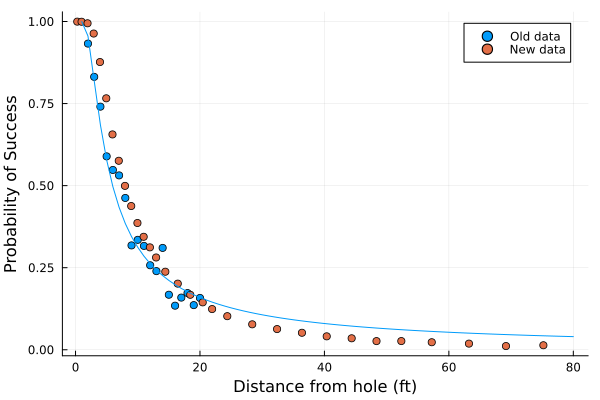

In [74]:
# plot the old model fit with new data
threshold_angle2 = [asin((R - r) / x) for x = xrngnew]
geom_lines2 = prob_angle(threshold_angle2, post_sigma)

scatter(
  x, pj,
  label = "Old data",
  ylab = "Probability of Success",
  xlab = "Distance from hole (ft)",
  color = 1)
scatter!(xnew, pnew, color = 2, label = "New data")
plot!(geom_lines2, label = "", color = 1)

#### Updated Geometry

$$
\Bigg(2Φ\Bigg(\frac{\sin^{-1}((R-r)/x)}{σ_{\text{angle}}}\Bigg)^{-1}\Bigg) \cdot \Bigg(\Phi\Bigg(\frac{2}{(x+1)σ_{\text{distance}}}\Bigg) - \Phi\Bigg(\frac{-1}{(x+1)σ_{\text{distance}}}\Bigg)\Bigg) 
$$

In [75]:
prob_distance(distance, tol, overshot, σ) =
  Φ((tol - overshot) ./ ((distance .+ overshot) * σ)) -
    Φ(-overshot ./ ((distance .+ overshot) * σ));

In [76]:
@model golf_angle_dist(x, y, n, J, r, R, overshot, distance_tolerance) = begin
  # transformed data
  threshold_angle = asin.((R - r) ./ x)

  # parameters
  sigma_angle ~ truncated(Normal(0, 1), 0, Inf)
  sigma_distance ~ truncated(Normal(0, 1), 0, Inf)

  # model
  p_angle = prob_angle(threshold_angle, sigma_angle)
  p_distance = prob_distance(x, distance_tolerance, overshot, sigma_distance)
  p = p_angle .* p_distance

  for i in 1:J
    y[i] ~ Binomial(n[i], p[i])
  end
end

golf_angle_dist (generic function with 2 methods)

In [77]:
overshot = 1.
distance_tolerance = 3.

chn3 = sample(
  golf_angle_dist(xnew, ynew, nnew, length(xnew), r, R, overshot, distance_tolerance),
  NUTS(),
  MCMCThreads(),
  6000,
  4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.003125


Chains MCMC chain (6000×14×4 Array{Float64, 3}):

Iterations        = 1001:1:7000
Number of chains  = 4
Samples per chain = 6000
Wall duration     = 4.69 seconds
Compute duration  = 4.31 seconds
parameters        = sigma_angle, sigma_distance
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
      parameters      mean       std      mcse   ess_bulk   ess_tail      rhat ⋯
          Symbol   Float64   Float64   Float64    Float64    Float64   Float64 ⋯

     sigma_angle    0.0303    0.0170    0.0025    72.1657   980.9356    1.7341 ⋯
  sigma_distance    0.0994    0.0392    0.0057    58.2687    74.7147    2.9814 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64  

In [78]:
prettystats(chn3)

parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
sigma_angle,0.03,0.017,0.002,72.166,980.936,1.734,16.759
sigma_distance,0.099,0.039,0.006,58.269,74.715,2.981,13.532


In [80]:
# calculate predictions
post_siga = median(chn3[:sigma_angle])
post_sigd = median(chn3[:sigma_distance])

p_angle = prob_angle(threshold_angle2, post_siga)
p_distance = prob_distance(xrngnew, distance_tolerance, overshot, post_sigd)

geom2_lines = p_angle .* p_distance;

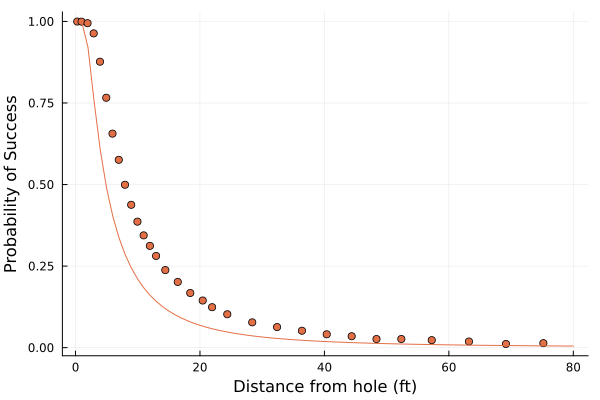

In [81]:
# plot
scatter(
  xnew, pnew,
  legend = false,
  color = 2,
  ylab = "Probability of Success",
  xlab = "Distance from hole (ft)")
plot!(geom2_lines, color = 2)

To fix this problem we took the data model, $$y_j∼binomial(n_j,p_j)$$
, and added an independent error term to each observation.

…we first approximate the binomial data distribution by a normal and then add independent variance; thus:
$$y_j/n_j ∼ normal(p_j,\sqrt{(p_j(1−p_j)/n_j+σ_y^2)})$$

#### &#x1F32B; A Dispersed Model

In [82]:
@model golf_angle_dist_resid(x, y, n, J, r, R, overshot, distance_tolerance, raw) = begin
  # transformed data
  threshold_angle = asin.((R - r) ./ x)

  # parameters
  sigma_angle ~ truncated(Normal(0, 1), 0, Inf)
  sigma_distance ~ truncated(Normal(0, 1), 0, Inf)
  sigma_y ~ truncated(Normal(0, 1), 0, Inf)

  # model
  p_angle = prob_angle(threshold_angle, sigma_angle)
  p_distance = prob_distance(x, distance_tolerance, overshot, sigma_distance)
  p = p_angle .* p_distance

  for i in 1:J
    raw[i] ~ Normal(p[i], sqrt(p[i] * (1-p[i]) / n[i] + sigma_y^2))
  end
end

golf_angle_dist_resid (generic function with 2 methods)

In [83]:
chn4 = sample(
  golf_angle_dist_resid(xnew, ynew, nnew, length(xnew), r, R, overshot, distance_tolerance, ynew ./ nnew),
  NUTS(),
  MCMCThreads(),
  4000,
  4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4


Chains MCMC chain (4000×15×4 Array{Float64, 3}):

Iterations        = 1001:1:5000
Number of chains  = 4
Samples per chain = 4000
Wall duration     = 5.19 seconds
Compute duration  = 4.9 seconds
parameters        = sigma_angle, sigma_distance, sigma_y
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
      parameters      mean       std      mcse    ess_bulk    ess_tail      rh ⋯
          Symbol   Float64   Float64   Float64     Float64     Float64   Float ⋯

     sigma_angle    0.0178    0.0001    0.0000   7460.5522   8107.0538    1.00 ⋯
  sigma_distance    0.0801    0.0013    0.0000   7211.1183   7794.6535    1.00 ⋯
         sigma_y    0.0030    0.0006    0.0000   9202.2463   7658.7717    1.00 ⋯
                                                               2 columns omitted

Quantiles
      parameters      2.5% 

In [105]:
# adding the conversion to degrees
#chns = hcat(chn4[:sigma_angle], Chains(chn4[:sigma_angle] * 180 / π, ["sigma_degrees"]))
# chn4[:sigma_angle] * 180 / π

In [108]:
prettystats(chn4)

parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
sigma_angle,0.018,0.0,0.0,7460.55,8107.05,1.001,1522.56
sigma_distance,0.08,0.001,0.0,7211.12,7794.65,1.001,1471.66
sigma_y,0.003,0.001,0.0,9202.25,7658.77,1.0,1878.01


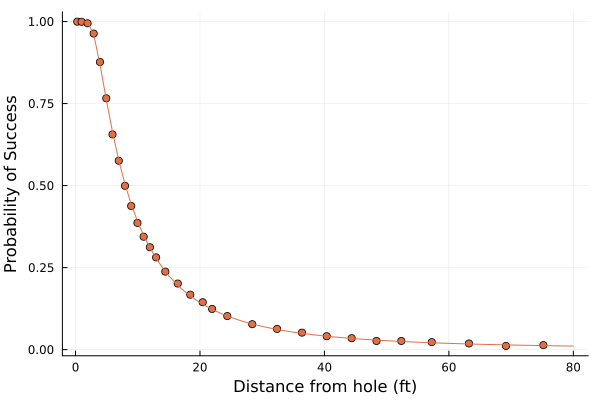

In [110]:
post_siga = median(chn4[:sigma_angle])
post_sigd = median(chn4[:sigma_distance])

p_angle2 = prob_angle(threshold_angle2, post_siga)
p_distance2 = prob_distance(xrngnew, distance_tolerance, overshot, post_sigd)

geom_lines2 = p_angle2 .* p_distance2

# plot
scatter(
  xnew, pnew,
  legend = false,
  color = 2,
  ylab = "Probability of Success",
  xlab = "Distance from hole (ft)")
plot!(geom_lines2, color = 2)

# References
- [ ] [Model building of golf putting with Turing.jl](https://jduncstats.com/posts/2019-11-02-golf-turing)
- [ ] [Get list of parameters from Turing model](https://discourse.julialang.org/t/get-list-of-parameters-from-turing-model/66278/5)

In [96]:
@model function mymodel(x)
    σ ~ Exponential()
    μ ~ Normal(2.0, 1.0)
    x .~ Normal(μ, σ) # |> iid(n)
    
    return μ, σ
end

mymodel (generic function with 2 methods)

In [97]:
m = mymodel([1.0, 2.0, 3.0])

DynamicPPL.Model{typeof(mymodel), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(mymodel, (x = [1.0, 2.0, 3.0],), NamedTuple(), DynamicPPL.DefaultContext())

In [98]:
ch = sample(m, NUTS(), 1000, discard_adapt=false, init_params=[0.5, 5])

┌ Info: Found initial step size
└   ϵ = 0.2


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.69 seconds
Compute duration  = 1.69 seconds
parameters        = σ, μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           σ    1.1864    0.5449    0.0278   391.9172   475.4804    1.0014     ⋯
           μ    2.0477    0.5876    0.0314   399.1232   308.2452    1.0079     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ 

In [101]:
σ, μ = DynamicPPL.syms(DynamicPPL.VarInfo(m))

(:σ, :μ)